In [1]:
import numpy as np
import pandas as pd
from skimage.transform import rotate, rescale
import matplotlib.pyplot as plt
from matplotlib.path import Path
import fiona
import shapely.geometry as geometry
from shapely.geometry import Point
from shapely.affinity import rotate
from descartes import PolygonPatch
import pylab as pl
import multiprocessing as mp
import pathlib
import datetime
from src import *

np.random.seed(99)

Some examples of the random two-dimentional objects that we are going to use. They are generated by concave hulls of random points in the two-dimentional space.

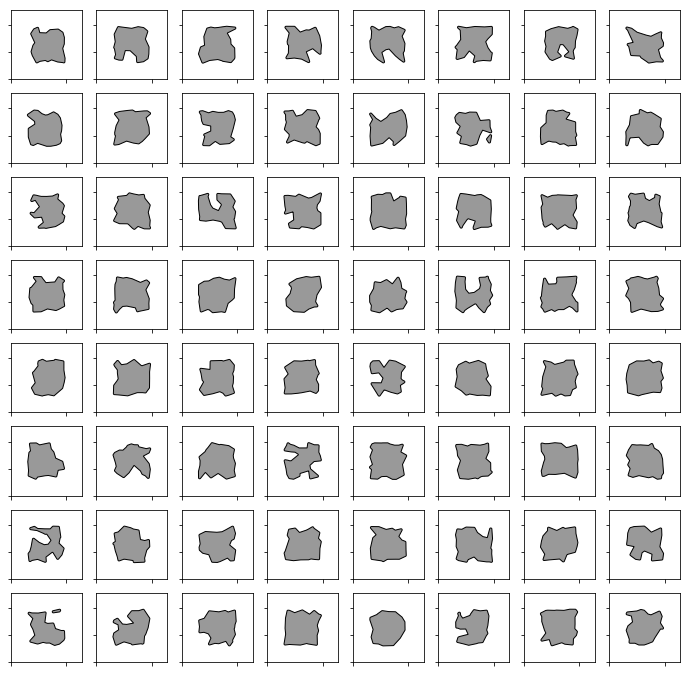

In [2]:
n_point = 60; alpha = .2
fig = pl.figure(figsize=(12,12))

for i in range(64):
    a = np.random.uniform(16,48,size=(n_point,2))
    points = [Point(a[i]) for i in range(n_point)]
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)

    ax = fig.add_subplot(8,8,i+1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim([0, 64]) #ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([0, 64])
    patch = PolygonPatch(concave_hull.buffer(1), fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)    

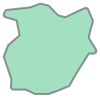

In [3]:
concave_hull.buffer(1)

# Data generation

We will study on 100.000 randomly generated two-dimentional objects. For each object, we take 1.000 one-dimentional image by taking integrals.

In [ ]:
%%time
# We write the generated one-dimentional images and their rotation 
# angles to the hdf5 file in batches. Polygons are generated in parallel.
batches = 500
num_of_polygons = 100000
num_image_per_polygon = 1000
loop_n = num_of_polygons // batches

# allows for breaks in the data generation process. 
# will continue from where it's left off
loop_start_i = 0
last_id = 0
if (pathlib.Path('generated_data.h5').exists()):
    store = pd.HDFStore('generated_data.h5')
    loop_start_i = store.get_storer('gen_data').nrows // (num_image_per_polygon * batches) - 1
    last_id = store.get_storer('gen_data').nrows // num_image_per_polygon
    store.close()


for i in range (loop_start_i, loop_n):
    t1= datetime.datetime.now() # for measuring runtime of the loop
    pool = mp.Pool(processes=mp.cpu_count())
    results = pool.map(gen_rand_poly_images,[num_image_per_polygon] * batches )
    
    temp_df = pd.DataFrame(np.vstack([l[1] for l in results]))
    temp_df.columns = ['x_' + str(n) for n in range(temp_df.shape[1])]
    temp_df['object_id'] = np.repeat( range(len(results)),num_image_per_polygon).astype('int32') + last_id + 1
    temp_df['angles'] = np.hstack([l[0] for l in results])
    last_id = (len(results) + last_id)
    
    temp_df.to_hdf('generated_data.h5',key='gen_data', append=True, mode='a', format='t')
    t2 = datetime.datetime.now() # for measuring runtime of the loop
    print(str(last_id)+' | '+ str(t2 -t1) )
    

580 | 0:09:33.462913
1080 | 0:10:30.245488
